# Data Preparation
In the first step we load the data set; filter it based on the occupational code and clean it.

In [1]:
#importing the necessary libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
#loading the dataset
data = pd.read_csv('morg-2014-emp.csv', low_memory= False)
data.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


## Filtering the data based on the occupational codes
We are going to continue with **__Arts, Design, Entertainment, Sports, and Media Occupations__** in this assignment.

In [3]:
#filtering data based on the Occupational code
filtered_data = data[(data['occ2012'] >= 2600) & (data['occ2012'] <= 2920)]

* Checking the data types to make the necessary adjustments

In [4]:
filtered_data.dtypes

Unnamed: 0      int64
hhid            int64
intmonth       object
stfips         object
weight        float64
earnwke       float64
uhours          int64
grade92         int64
race            int64
ethnic        float64
age             int64
sex             int64
marital         int64
ownchild        int64
chldpres        int64
prcitshp       object
state          object
ind02          object
occ2012         int64
class          object
unionmme       object
unioncov       object
lfsr94         object
dtype: object

In [5]:
# converting the categorical columns from object to categorical type

cat_cols = [
    'intmonth','stfips','prcitshp', 'ind02','class', 'unionmme','unioncov',
    'lfsr94', 'race', 'ethnic', 'sex', 'marital','occ2012' 
]
for col in cat_cols:
    filtered_data[col] = pd.Categorical(filtered_data[col])

C:\Users\PA\AppData\Local\Temp\ipykernel_7564\2183723912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = pd.Categorical(filtered_data[col])
C:\Users\PA\AppData\Local\Temp\ipykernel_7564\2183723912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = pd.Categorical(filtered_data[col])
C:\Users\PA\AppData\Local\Temp\ipykernel_7564\2183723912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

# Missing values, checking and handling
First, let's see which variables include missing values and how can we get rid of them.

In [6]:
missing_values = filtered_data.isnull().sum()
missing_values

Unnamed: 0       0
hhid             0
intmonth         0
stfips           0
weight           0
earnwke          0
uhours           0
grade92          0
race             0
ethnic        2107
age              0
sex              0
marital          0
ownchild         0
chldpres         0
prcitshp         0
state            0
ind02            0
occ2012          0
class            0
unionmme         0
unioncov       134
lfsr94           0
dtype: int64

* Only 2 variables have misisng values and for these 2, it is plausible to replace the missing values with the modes.

In [7]:
# fill missing values with mode
filtered_data['ethnic'].fillna(filtered_data['ethnic'].mode()[0], inplace=True)
filtered_data['unioncov'].fillna(filtered_data['unioncov'].mode()[0], inplace=True)


C:\Users\PA\AppData\Local\Temp\ipykernel_7564\777822520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ethnic'].fillna(filtered_data['ethnic'].mode()[0], inplace=True)
C:\Users\PA\AppData\Local\Temp\ipykernel_7564\777822520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['unioncov'].fillna(filtered_data['unioncov'].mode()[0], inplace=True)


In [8]:
# Creating a new variable for hourly wage (with the help of github copilot, to avoid the warning)
filtered_data['hourly_wage'] = filtered_data['earnwke'].div(filtered_data['uhours'])

C:\Users\PA\AppData\Local\Temp\ipykernel_7564\4108458704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hourly_wage'] = filtered_data['earnwke'].div(filtered_data['uhours'])


### Converting the categorical variables to dummies
* When we convert a categorical variable to a set of dummies, the sufficient number of dummies is the number of categories minus 1. This is the reason that we drop the first category.
* Also, after creating the set of dummies we exclude the original variable.

In [9]:
# Converting the categorical variables to dummies
filtered_data = pd.get_dummies(filtered_data, columns = cat_cols, drop_first= True )

In [10]:
drop_cols = cat_cols + ['Unnamed: 0','hhid', 'earnwke', 'uhours','state']

In [11]:
keep_cols= [i for i in filtered_data.columns if i not in drop_cols]
df = filtered_data[keep_cols].copy()
df = df.reset_index(drop=True)

* Storing the cleaned data in a new csv file

In [12]:
df.to_csv('cleaned_filtered_numeric_data.csv')

In [13]:
df

,weight,grade92,age,ownchild,chldpres,hourly_wage,intmonth_August,intmonth_December,intmonth_February,intmonth_January,...,occ2012_2800,occ2012_2810,occ2012_2825,occ2012_2830,occ2012_2840,occ2012_2850,occ2012_2860,occ2012_2900,occ2012_2910,occ2012_2920
0,3202.3739,40,23,0,0,8.350000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9206.4248,40,23,0,0,7.750000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1533.1598,43,35,2,8,22.200000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1616.3952,40,27,1,1,17.500000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1833.6081,37,17,0,0,13.500000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,3374.2812,43,32,1,1,19.230750,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2311,3677.2160,39,50,1,4,10.357143,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2312,3814.6828,43,57,0,0,23.397222,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2313,325.7699,41,36,2,8,38.450000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


* Now as we can see, we have almost 300 explanatory variables. We will use LASSO to get rid of non-important features. Then we'll use the rest of the features for implementing the regression model.

In [14]:
# importing the necessary libraries for LASSO
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [15]:
# Separating the target variable and the independent variables
X = df.drop('hourly_wage', axis=1)
y = df['hourly_wage']

# normalizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

* To avoid the overfitting, we slpit the training and test sets before running the LASSO model.
* We split these sets using the **__train_test_split__** module from **__sklearn__** library.

In [16]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=123)

* We use the cross validition with 5 folds to choose the best value for the regulization parameter.

In [17]:
alphas = np.logspace(-6, 2, 100)
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)
# Stoing the best lambda value
selected_alpha = lasso_cv.alpha_

c:\Users\PA\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.22171199461445, tolerance: 40.96758572217973
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\PA\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.84160925738979, tolerance: 40.96758572217973
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\PA\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.90087860677158, tolerance: 40.96758572217973
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\PA\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWar

* In this step we use the selected value of **__alpha__** to train tha LASSO model and exclude non-important features.

In [18]:
from sklearn.linear_model import Lasso
best_model = Lasso(alpha=selected_alpha)
best_model.fit(X_train, y_train)

Lasso(alpha=0.5462277217684348)

In [19]:
selected_features = X.columns[best_model.coef_ != 0]
print(selected_features)

Index(['grade92', 'age', 'chldpres', 'stfips_CA', 'stfips_CT', 'stfips_DC',
       'stfips_KS', 'stfips_MS', 'stfips_NC', 'stfips_NV', 'stfips_NY',
       'stfips_OH', 'stfips_RI', 'stfips_TN', 'stfips_TX', 'stfips_WA',
       'stfips_WI', 'prcitshp_Foreign Born, US Cit By Naturalization',
       'prcitshp_Native, Born In US',
       'ind02_** Apparel, fabrics, and notions, merchant wholesalers (*4243)',
       'ind02_5275', 'ind02_Book stores and news dealers (45121)',
       'ind02_Building material and supplies dealers (4441 exc. 44413)',
       'ind02_Computer systems design and related services (5415)',
       'ind02_Electronic component and product manufacturing, n.e.c. (3344, 3346)',
       'ind02_Furniture and home furnishings stores (442)',
       'ind02_Grocery stores (4451)',
       'ind02_Independent artists, performing arts, spectator sports, and related industries (711)',
       'ind02_Industrial and miscellaneous chemicals (3251, 3259)',
       'ind02_Management, scienti

In [20]:
"""# Dropping the features that are not selected by LASSO
X_train_selected = X_train[:, best_model.coef_ != 0]
X_test_selected = X_test[:, best_model.coef_ != 0]
X_scaled_selected = X_scaled[:, best_model.coef_ != 0] """

'# Dropping the features that are not selected by LASSO\nX_train_selected = X_train[:, best_model.coef_ != 0]\nX_test_selected = X_test[:, best_model.coef_ != 0]\nX_scaled_selected = X_scaled[:, best_model.coef_ != 0] '

# Model 0

In [21]:
# Creating lists to store the RMSE and BIC values
RMSE_full_sample = []
RMSE_CV = []
BIC_full_sample = []

In [22]:
zero_features = ['grade92', 'race', 'sex']
model_0_features = ['age']
for feat in zero_features:
    model_0_features += [i for i in selected_features if feat in i]

model_0_features

['age', 'grade92', 'race_4', 'race_8', 'sex_2']

In [23]:
X_scaled_model_0 = X_scaled[:, [i for i in range(X_scaled.shape[1]) if X.columns[i] in model_0_features]]
X_scaled_model_0.shape

(2315, 5)

In [24]:
# Building the OLS model using cross validation
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
model0 = LinearRegression()
y_pred_cv = cross_val_predict(model0, X_scaled_model_0, y, cv=5)
rmse_cv_value = np.sqrt(mean_squared_error(y, y_pred_cv))
RMSE_CV.append(rmse_cv_value)
print(rmse_cv_value)

25.301824144272633


In [25]:
# Building the OLS model using full sample and calculating the RMSE and BIC
X_scaled_model_0 = sm.add_constant(X_scaled_model_0)
model0_full_sample = sm.OLS(y, X_scaled_model_0).fit()
y_pred_full_sample = model0_full_sample.predict(X_scaled_model_0)
rmse_full_sample_value = np.sqrt(mean_squared_error(y, y_pred_full_sample))
RMSE_full_sample.append(rmse_full_sample_value)
BIC_full_sample.append(model0_full_sample.bic)
print('RMSE of OLS model with full sample is: ', rmse_full_sample_value)
print('BIC of OLS model with full sample is: ', model0_full_sample.bic)


RMSE of OLS model with full sample is:  25.271251158873717
BIC of OLS model with full sample is:  21569.52860778832


# Model 1

In [26]:
basic_features = ['grade92', 'race', 'ethnic', 'sex', 'marital','prcitshp','unionmme', 'unioncov', 'lfsr94', 'intmonth']
model_1_features = ['age']
for feat in basic_features:
    model_1_features += [i for i in selected_features if feat in i]

model_1_features


['age',
 'grade92',
 'race_4',
 'race_8',
 'sex_2',
 'marital_4',
 'marital_5',
 'marital_7',
 'prcitshp_Foreign Born, US Cit By Naturalization',
 'prcitshp_Native, Born In US',
 'unionmme_Yes']

In [27]:
X_scaled_model_1 = X_scaled[:, [i for i in range(len(X.columns)) if X.columns[i] in model_1_features]]
X_scaled_model_1.shape

(2315, 11)

In [28]:
# Building the OLS model using cross validation
model1 = LinearRegression()
y_pred_cv = cross_val_predict(model1, X_scaled_model_1, y, cv=5)
rmse_cv_value = np.sqrt(mean_squared_error(y, y_pred_cv))
RMSE_CV.append(rmse_cv_value)

print('RMSE of OLS model with cross validation is: ', rmse_cv_value)

RMSE of OLS model with cross validation is:  25.293657984819756


In [29]:
# Building the OLS model using full sample and calculating the RMSE and BIC
X_scaled_model_1 = sm.add_constant(X_scaled_model_1)
model1_full_sample = sm.OLS(y, X_scaled_model_1).fit()
y_pred_full_sample = model1_full_sample.predict(X_scaled_model_1)
rmse_full_sample_value = np.sqrt(mean_squared_error(y, y_pred_full_sample))
RMSE_full_sample.append(rmse_full_sample_value)
BIC_full_sample.append(model1_full_sample.bic)
print('RMSE of OLS model with full sample is: ', rmse_full_sample_value)
print('BIC of OLS model with full sample is: ', model1_full_sample.bic)

RMSE of OLS model with full sample is:  25.16556906651321
BIC of OLS model with full sample is:  21596.608756506823


# Model 2

In [30]:
extra_features = ['ownchild', 'chldpres', 'class']
model_2_features = []
model_2_features = model_1_features
for feat in extra_features:
    model_2_features += [i for i in selected_features if feat in i]
model_2_features

['age',
 'grade92',
 'race_4',
 'race_8',
 'sex_2',
 'marital_4',
 'marital_5',
 'marital_7',
 'prcitshp_Foreign Born, US Cit By Naturalization',
 'prcitshp_Native, Born In US',
 'unionmme_Yes',
 'chldpres',
 'class_Government - State']

In [31]:
X_scaled_model_2 = X_scaled[:, [i for i in range(len(X.columns)) if X.columns[i] in model_2_features]]
X_scaled_model_2.shape

(2315, 13)

In [32]:
# Building the 2nd OLS model using cross validation
model2 = LinearRegression()
y_pred_cv = cross_val_predict(model2, X_scaled_model_2, y, cv=5)
rmse_cv_value = np.sqrt(mean_squared_error(y, y_pred_cv))
RMSE_CV.append(rmse_cv_value)
print('RMSE of OLS model with cross validation is: ', rmse_cv_value)

RMSE of OLS model with cross validation is:  25.247284818410307


In [33]:
# Evaluating the OLS model using full sample and calculating the RMSE and BIC
X_scaled_model_2 = sm.add_constant(X_scaled_model_2)
model2_full_sample = sm.OLS(y, X_scaled_model_2).fit()
y_pred_full_sample = model2_full_sample.predict(X_scaled_model_2)
rmse_full_sample_value = np.sqrt(mean_squared_error(y, y_pred_full_sample))
RMSE_full_sample.append(rmse_full_sample_value)
BIC_full_sample.append(model2_full_sample.bic)
print('RMSE of OLS model with full sample is: ', rmse_full_sample_value)
print('BIC of OLS model with full sample is: ', model2_full_sample.bic)

RMSE of OLS model with full sample is:  25.11443298702469
BIC of OLS model with full sample is:  21602.68542056904


# Model 3

In [34]:
model_3_features = selected_features
X_scaled_model_3 = X_scaled[:, [i for i in range(len(X.columns)) if X.columns[i] in model_3_features]]
X_scaled_model_3.shape

(2315, 57)

In [35]:
# Building the 3rd OLS model using cross validation
model3 = LinearRegression()
y_pred_cv = cross_val_predict(model3, X_scaled_model_3, y, cv=5)
rmse_cv_value = np.sqrt(mean_squared_error(y, y_pred_cv))
RMSE_CV.append(rmse_cv_value)
print('RMSE of OLS model with cross validation is: ', rmse_cv_value)

RMSE of OLS model with cross validation is:  25.12315573289413


In [36]:
# Evaluating the 3rd OLS model using full sample and calculating the RMSE and BIC
X_scaled_model_3 = sm.add_constant(X_scaled_model_3)
model3_full_sample = sm.OLS(y, X_scaled_model_3).fit()
y_pred_full_sample = model3_full_sample.predict(X_scaled_model_3)
rmse_full_sample_value = np.sqrt(mean_squared_error(y, y_pred_full_sample))
RMSE_full_sample.append(rmse_full_sample_value)
BIC_full_sample.append(model3_full_sample.bic)
print('RMSE of OLS model with full sample is: ', rmse_full_sample_value)
print('BIC of OLS model with full sample is: ', model3_full_sample.bic)

RMSE of OLS model with full sample is:  24.658807728491034
BIC of OLS model with full sample is:  21858.792082817345


# Model 4

In [39]:
# Building the 4th OLS model, by including some interaction terms and some polynomial terms
from itertools import combinations
X_cp = X.copy()
model_4_features = model_1_features
for i in range(2, 3):
    for comb in combinations(model_1_features, i):
        new_feature = '*'.join(comb)
        X_cp[new_feature]= X_cp[list(comb)].prod(axis=1)
        model_4_features.append(new_feature)

model_4_features


['age',
 'grade92',
 'race_4',
 'race_8',
 'sex_2',
 'marital_4',
 'marital_5',
 'marital_7',
 'prcitshp_Foreign Born, US Cit By Naturalization',
 'prcitshp_Native, Born In US',
 'unionmme_Yes',
 'chldpres',
 'class_Government - State',
 'age*grade92',
 'age*race_4',
 'age*race_8',
 'age*sex_2',
 'age*marital_4',
 'age*marital_5',
 'age*marital_7',
 'age*prcitshp_Foreign Born, US Cit By Naturalization',
 'age*prcitshp_Native, Born In US',
 'age*unionmme_Yes',
 'age*chldpres',
 'age*class_Government - State',
 'grade92*race_4',
 'grade92*race_8',
 'grade92*sex_2',
 'grade92*marital_4',
 'grade92*marital_5',
 'grade92*marital_7',
 'grade92*prcitshp_Foreign Born, US Cit By Naturalization',
 'grade92*prcitshp_Native, Born In US',
 'grade92*unionmme_Yes',
 'grade92*chldpres',
 'grade92*class_Government - State',
 'race_4*race_8',
 'race_4*sex_2',
 'race_4*marital_4',
 'race_4*marital_5',
 'race_4*marital_7',
 'race_4*prcitshp_Foreign Born, US Cit By Naturalization',
 'race_4*prcitshp_Native

In [40]:
X_cp

,weight,grade92,age,ownchild,chldpres,intmonth_August,intmonth_December,intmonth_February,intmonth_January,intmonth_July,...,"prcitshp_Foreign Born, US Cit By Naturalization*prcitshp_Native, Born In US","prcitshp_Foreign Born, US Cit By Naturalization*unionmme_Yes","prcitshp_Foreign Born, US Cit By Naturalization*chldpres","prcitshp_Foreign Born, US Cit By Naturalization*class_Government - State","prcitshp_Native, Born In US*unionmme_Yes","prcitshp_Native, Born In US*chldpres","prcitshp_Native, Born In US*class_Government - State",unionmme_Yes*chldpres,unionmme_Yes*class_Government - State,chldpres*class_Government - State
0,3202.3739,40,23,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,9206.4248,40,23,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1533.1598,43,35,2,8,0,0,0,1,0,...,0,0,0,0,0,8,0,0,0,0
3,1616.3952,40,27,1,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1833.6081,37,17,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,3374.2812,43,32,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2311,3677.2160,39,50,1,4,0,1,0,0,0,...,0,0,0,0,0,4,0,0,0,0
2312,3814.6828,43,57,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313,325.7699,41,36,2,8,0,1,0,0,0,...,0,0,0,0,0,8,0,0,0,0


In [41]:
X_cp_scaled = scaler.fit_transform(X_cp)
X_scaled_model_4 = X_cp_scaled[:, [i for i in range(len(X_cp.columns)) if X_cp.columns[i] in model_4_features]]
X_scaled_model_4.shape

(2315, 91)

In [42]:
# Building the 4th OLS model using cross validation
model4 = LinearRegression()
y_pred_cv = cross_val_predict(model4, X_scaled_model_4, y, cv=5)
rmse_cv_value = np.sqrt(mean_squared_error(y, y_pred_cv))
RMSE_CV.append(rmse_cv_value)
print('RMSE of OLS model with cross validation is: ', rmse_cv_value)

RMSE of OLS model with cross validation is:  5273751180477.756


In [43]:
# Building the 4th OLS model, by including some interaction terms and some polynomial terms
X_scaled_model_4 = sm.add_constant(X_scaled_model_4)
model4_full_sample = sm.OLS(y, X_scaled_model_4).fit()
y_pred_full_sample = model4_full_sample.predict(X_scaled_model_4)
rmse_full_sample_value = np.sqrt(mean_squared_error(y, y_pred_full_sample))
RMSE_full_sample.append(rmse_full_sample_value)
BIC_full_sample.append(model4_full_sample.bic)
print('RMSE of OLS model with full sample is: ', rmse_full_sample_value)
print('BIC of OLS model with full sample is: ', model4_full_sample.bic)

RMSE of OLS model with full sample is:  24.707720385684382
BIC of OLS model with full sample is:  22046.151744536


In [45]:
# Creating a dataframe to store the RMSE and BIC values
results = pd.DataFrame()
results['RMSE_CV'] = RMSE_CV
results['RMSE_full_sample'] = RMSE_full_sample
results['BIC_full_sample'] = BIC_full_sample
results.index = ['model_0', 'model_1', 'model_2', 'model_3', 'model_4']
results


,RMSE_CV,RMSE_full_sample,BIC_full_sample
model_0,2.530182e+01,25.271251,21569.528608
model_1,2.529366e+01,25.165569,21596.608757
model_2,2.524728e+01,25.114433,21602.685421
model_3,2.512316e+01,24.658808,21858.792083
model_4,5.273751e+12,24.707720,22046.151745


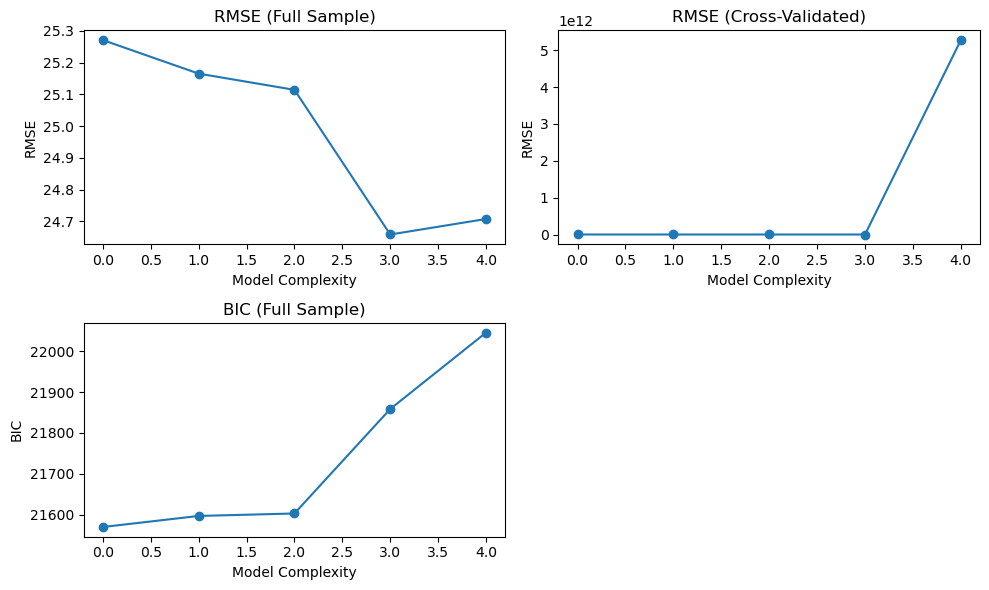

In [46]:
import matplotlib.pyplot as plt
model_complexity = range(0, 5)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(model_complexity, RMSE_full_sample, marker='o')
plt.title('RMSE (Full Sample)')
plt.xlabel('Model Complexity')
plt.ylabel('RMSE')

plt.subplot(2, 2, 2)
plt.plot(model_complexity, RMSE_CV, marker='o')
plt.title('RMSE (Cross-Validated)')
plt.xlabel('Model Complexity')
plt.ylabel('RMSE')

plt.subplot(2, 2, 3)
plt.plot(model_complexity, BIC_full_sample, marker='o')
plt.title('BIC (Full Sample)')
plt.xlabel('Model Complexity')
plt.ylabel('BIC')

plt.tight_layout()
plt.show()